In [1]:
import numpy as np
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
import pickle

In [3]:
with open('data.pickle', 'rb') as lb:
    rdata = pickle.load(lb)
    edge_indexes,features,surf_filters,ys = rdata

In [4]:
tmp = []
for item in features:
    tmp.append(item[:,-3:])
features = np.array(tmp)

In [5]:
features

array([array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]),
       array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]),
       array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [0

In [6]:
data_list = []
for i in range(len(ys)):
    edge_index = torch.tensor(edge_indexes[i], dtype=torch.long)
    x = torch.tensor(features[i], dtype=torch.float)
    surf_filter = torch.tensor(surf_filters[i], dtype=torch.long)
    y = torch.tensor(ys[i], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, surf_filter=surf_filter, y=y)
    data_list.append(data)

In [7]:
in_channels = len(data_list[0].x[0])
in_channels

3

In [8]:
import torch.nn.functional as F
from torch_geometric.nn import CGConv

class Net(torch.nn.Module):
    def __init__(self, in_channels):
        super(Net, self).__init__()
        self.conv1 = CGConv(in_channels)
        self.conv2 = CGConv(in_channels)
        self.lin = torch.nn.Linear(in_channels, 1)
    
    def forward(self, data):
        x, edge_index, surf_filter = data.x, data.edge_index, data.surf_filter

        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = x * surf_filter.reshape(-1,1)
        x = torch.sum(x, dim=0) / torch.sum(surf_filter)
        y = self.lin(x)

        return y

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
data_list_ = data_list[269:288] # Pt_111

In [11]:
random.shuffle(data_list_)
train_list = data_list_[:int(len(data_list_)*0.67)]
test_list = data_list_[int(len(data_list_)*0.67):]

In [12]:
model = Net(in_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_list = []

In [13]:
def get_loss(model,data_list):
    totalloss = 0
    for data in data_list:
        data = data.to(device)
        out = model(data)
        loss = F.mse_loss(out, data.y) 
        totalloss += loss
    return totalloss/len(data_list)

In [14]:
def get_plot(model,data_list):
    y = []
    ypred = []
    for data in data_list:
        data = data.to(device)
        out = model(data)
        ypred.append(out)
        y.append(data.y)
    ypred = torch.tensor(ypred)
    y = torch.tensor(y)
    pp = np.linspace(min(y),max(y))
    plt.plot(y,ypred,'.')
    plt.plot(pp,pp)
    plt.show()

In [15]:
model.train()

for epoch in range(500):
    for data in train_list:
        optimizer.zero_grad()
        data = data.to(device)
        out = model.train()(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_list.append(get_loss(model.eval(),train_list))
    print('epoch %d' % epoch)

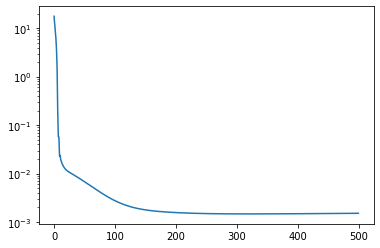

In [16]:
plt.plot(loss_list)
plt.yscale('log')
plt.show()

In [17]:
model.eval()

Net(
  (conv1): CGConv(3, dim=0)
  (conv2): CGConv(3, dim=0)
  (lin): Linear(in_features=3, out_features=1, bias=True)
)

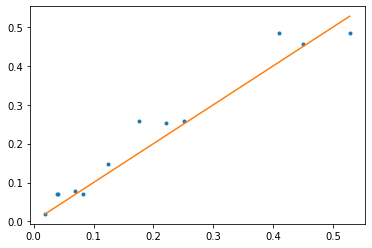

In [18]:
get_plot(model,train_list)

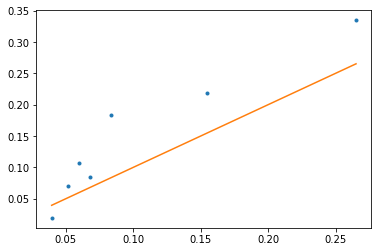

In [19]:
get_plot(model,test_list)

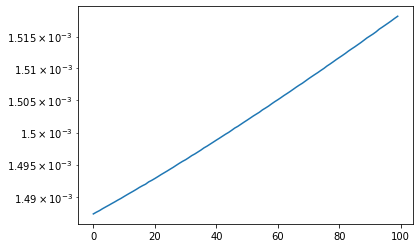

In [20]:
plt.plot(loss_list[-100:])
plt.yscale('log')
plt.show()

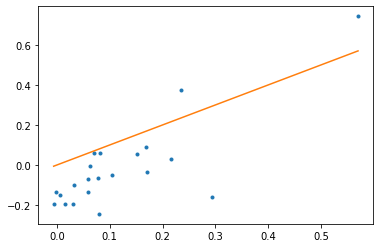

In [21]:
data_list_ = data_list[248:269] # Pt_100
get_plot(model,data_list_)

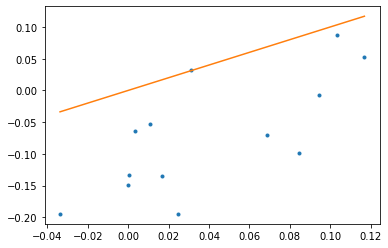

In [22]:
data_list_ = data_list[84:97] # Au_111
get_plot(model,data_list_)

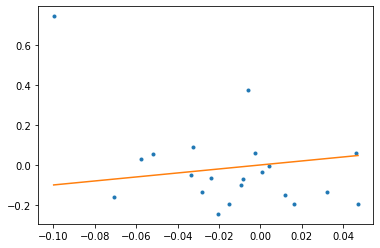

In [23]:
data_list_ = data_list[44:65] # Al_100
get_plot(model,data_list_)

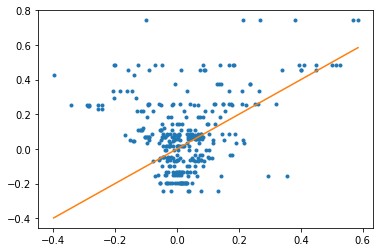

In [24]:
data_list_ = data_list # all
get_plot(model,data_list_)

In [25]:
loss_list[-1]**0.5

tensor(0.0390, device='cuda:0', grad_fn=<PowBackward0>)

In [26]:
get_loss(model,test_list)**0.5

tensor(0.0563, device='cuda:0', grad_fn=<PowBackward0>)

In [27]:
get_loss(model,data_list_)**0.5

tensor(0.2259, device='cuda:0', grad_fn=<PowBackward0>)